# Predicting Causal SNPs

In [1]:
# You can get rid of whatever libraries you dont need

import sys
import os
import random
import numpy as np
from numba import jit, prange
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_undirected, negative_sampling
import networkx as nx
from scipy.spatial import cKDTree
from scipy.special import expit
from typing import List, Dict
import time
import cProfile
import pstats
import io
import category_encoders as ce
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import copy
from torch_geometric.transforms import RandomNodeSplit
from collections import Counter



# Print versions of imported libraries
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Torch Geometric version: {torch_geometric.__version__}")
print(f"NetworkX version: {nx.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda")          # Current CUDA device
    print(f"Using {torch.cuda.get_device_name()} ({device})")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
else:
    print("CUDA is not available on this device.")

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.1
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Scikit-learn version: 1.3.0
Torch version: 2.0.1+cu117
Torch Geometric version: 2.3.1
NetworkX version: 3.0
Using NVIDIA RTX A6000 (cuda)
CUDA version: 11.7
Number of CUDA devices: 2


## Spec

### Data Description

The dataset is a Pandas DataFrame named `data`, which includes the following columns:

- `id`: Unique ID of the variant in the format #chrom:pos:ref:alt (string).
- `#chrom`: Chromosome number where the genetic variant is located.
- `pos`: Position of the genetic variant on the chromosome (integer between 1 and 200,000).
- `ref`: Reference allele (or variant) at the genomic position.
- `alt`: Alternate allele observed at the genomic position.
- `rsids`: Reference SNP cluster ID, a unique identifier for each variant used in the dbSNP database.
- `nearest_genes`: Gene nearest to the variant (string).
- `pval`: P-value, a statistical measure for the strength of evidence against the null hypothesis.
- `mlogp`: Minus log of the p-value, commonly used in genomic studies.
- `beta`: Beta coefficient, representing the effect size of the variant.
- `sebeta`: Standard error of the beta coefficient.
- `af_alt`: Allele frequency of the alternate variant in the general population (float between 0 and 1).
- `af_alt_cases`: Allele frequency of the alternate variant in the cases group (float between 0 and 1).
- `af_alt_controls`: Allele frequency of the alternate variant in the control group (float between 0 and 1).
- `finemapped`: Indicator whether the variant is included in the post-finemapped subset (1) or not (0) (integer).
- `precausal`: Indicator whether the variant is included in the precausal subset (1) or not (0) (integer).
- `causal`: Indicator whether the variant is included in the causal subset (1) or not (0) (integer).
- `trait`: Trait associated with the variant. In this dataset, it refers to the response to the drug paracetamol and NSAIDs.

### Data Subset 
From least likely to be causal (left) to most likely to be causal (right):

GWAS (20 million SNPs) --> Finemapped (3 million SNPs) --> Precausal (1300 SNPs) --> Causal (21 SNPs)

### Task Overview

The task is to build a binary classifier that predicts whether a SNP is included in the causal dataset (i.e., `causal=1`).

### Resources 
- FinnGen Docs: https://finngen.gitbook.io/documentation/
- GWAS YouTube Video: https://www.youtube.com/watch?v=sOP8WacfBM8

In [16]:
dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'finemapped': 'int64',
    'precausal': 'int64',
    'causal': 'int64'
}

data = pd.read_csv('hyp-finemapped-precausal.csv', dtype=dtypes)

# Assert column names
expected_columns = ['#chrom', 'pos', 'ref', 'alt', 'rsids', 'nearest_genes', 'pval', 'mlogp', 'beta',
                    'sebeta', 'af_alt', 'af_alt_cases', 'af_alt_controls',
                    'id', 'trait', 'precausal']
assert set(data.columns) == set(expected_columns), "Unexpected columns in the data DataFrame."

# Assert data types
expected_dtypes = {
    'id': 'string',
    '#chrom': 'int64',
    'pos': 'int64',
    'ref': 'string',
    'alt': 'string',
    'rsids': 'string',
    'nearest_genes': 'string',
    'pval': 'float64',
    'mlogp': 'float64',
    'beta': 'float64',
    'sebeta': 'float64',
    'af_alt': 'float64',
    'af_alt_cases': 'float64',
    'af_alt_controls': 'float64',
    'precausal': 'int64'
}

for col, expected_dtype in expected_dtypes.items():
    assert data[col].dtype == expected_dtype, f"Unexpected data type for column {col}."

In [19]:
missing_values = data['nearest_genes'].isna().sum()
print(f"The number of missing values in 'nearest_genes' is: {missing_values}")

The number of missing values in 'nearest_genes' is: 0


In [18]:
# Remove rows where 'nearest_genes' is missing
data = data.dropna(subset=['nearest_genes'])

# Check the new shape of the DataFrame
print(f"The shape of the data after removing missing 'nearest_genes': {data.shape}")

The shape of the data after removing missing 'nearest_genes': (7363, 16)


In [20]:
precausal_sum = data['precausal'].sum()
print(f"The sum of 'precausal' is: {precausal_sum}")


The sum of 'precausal' is: 283


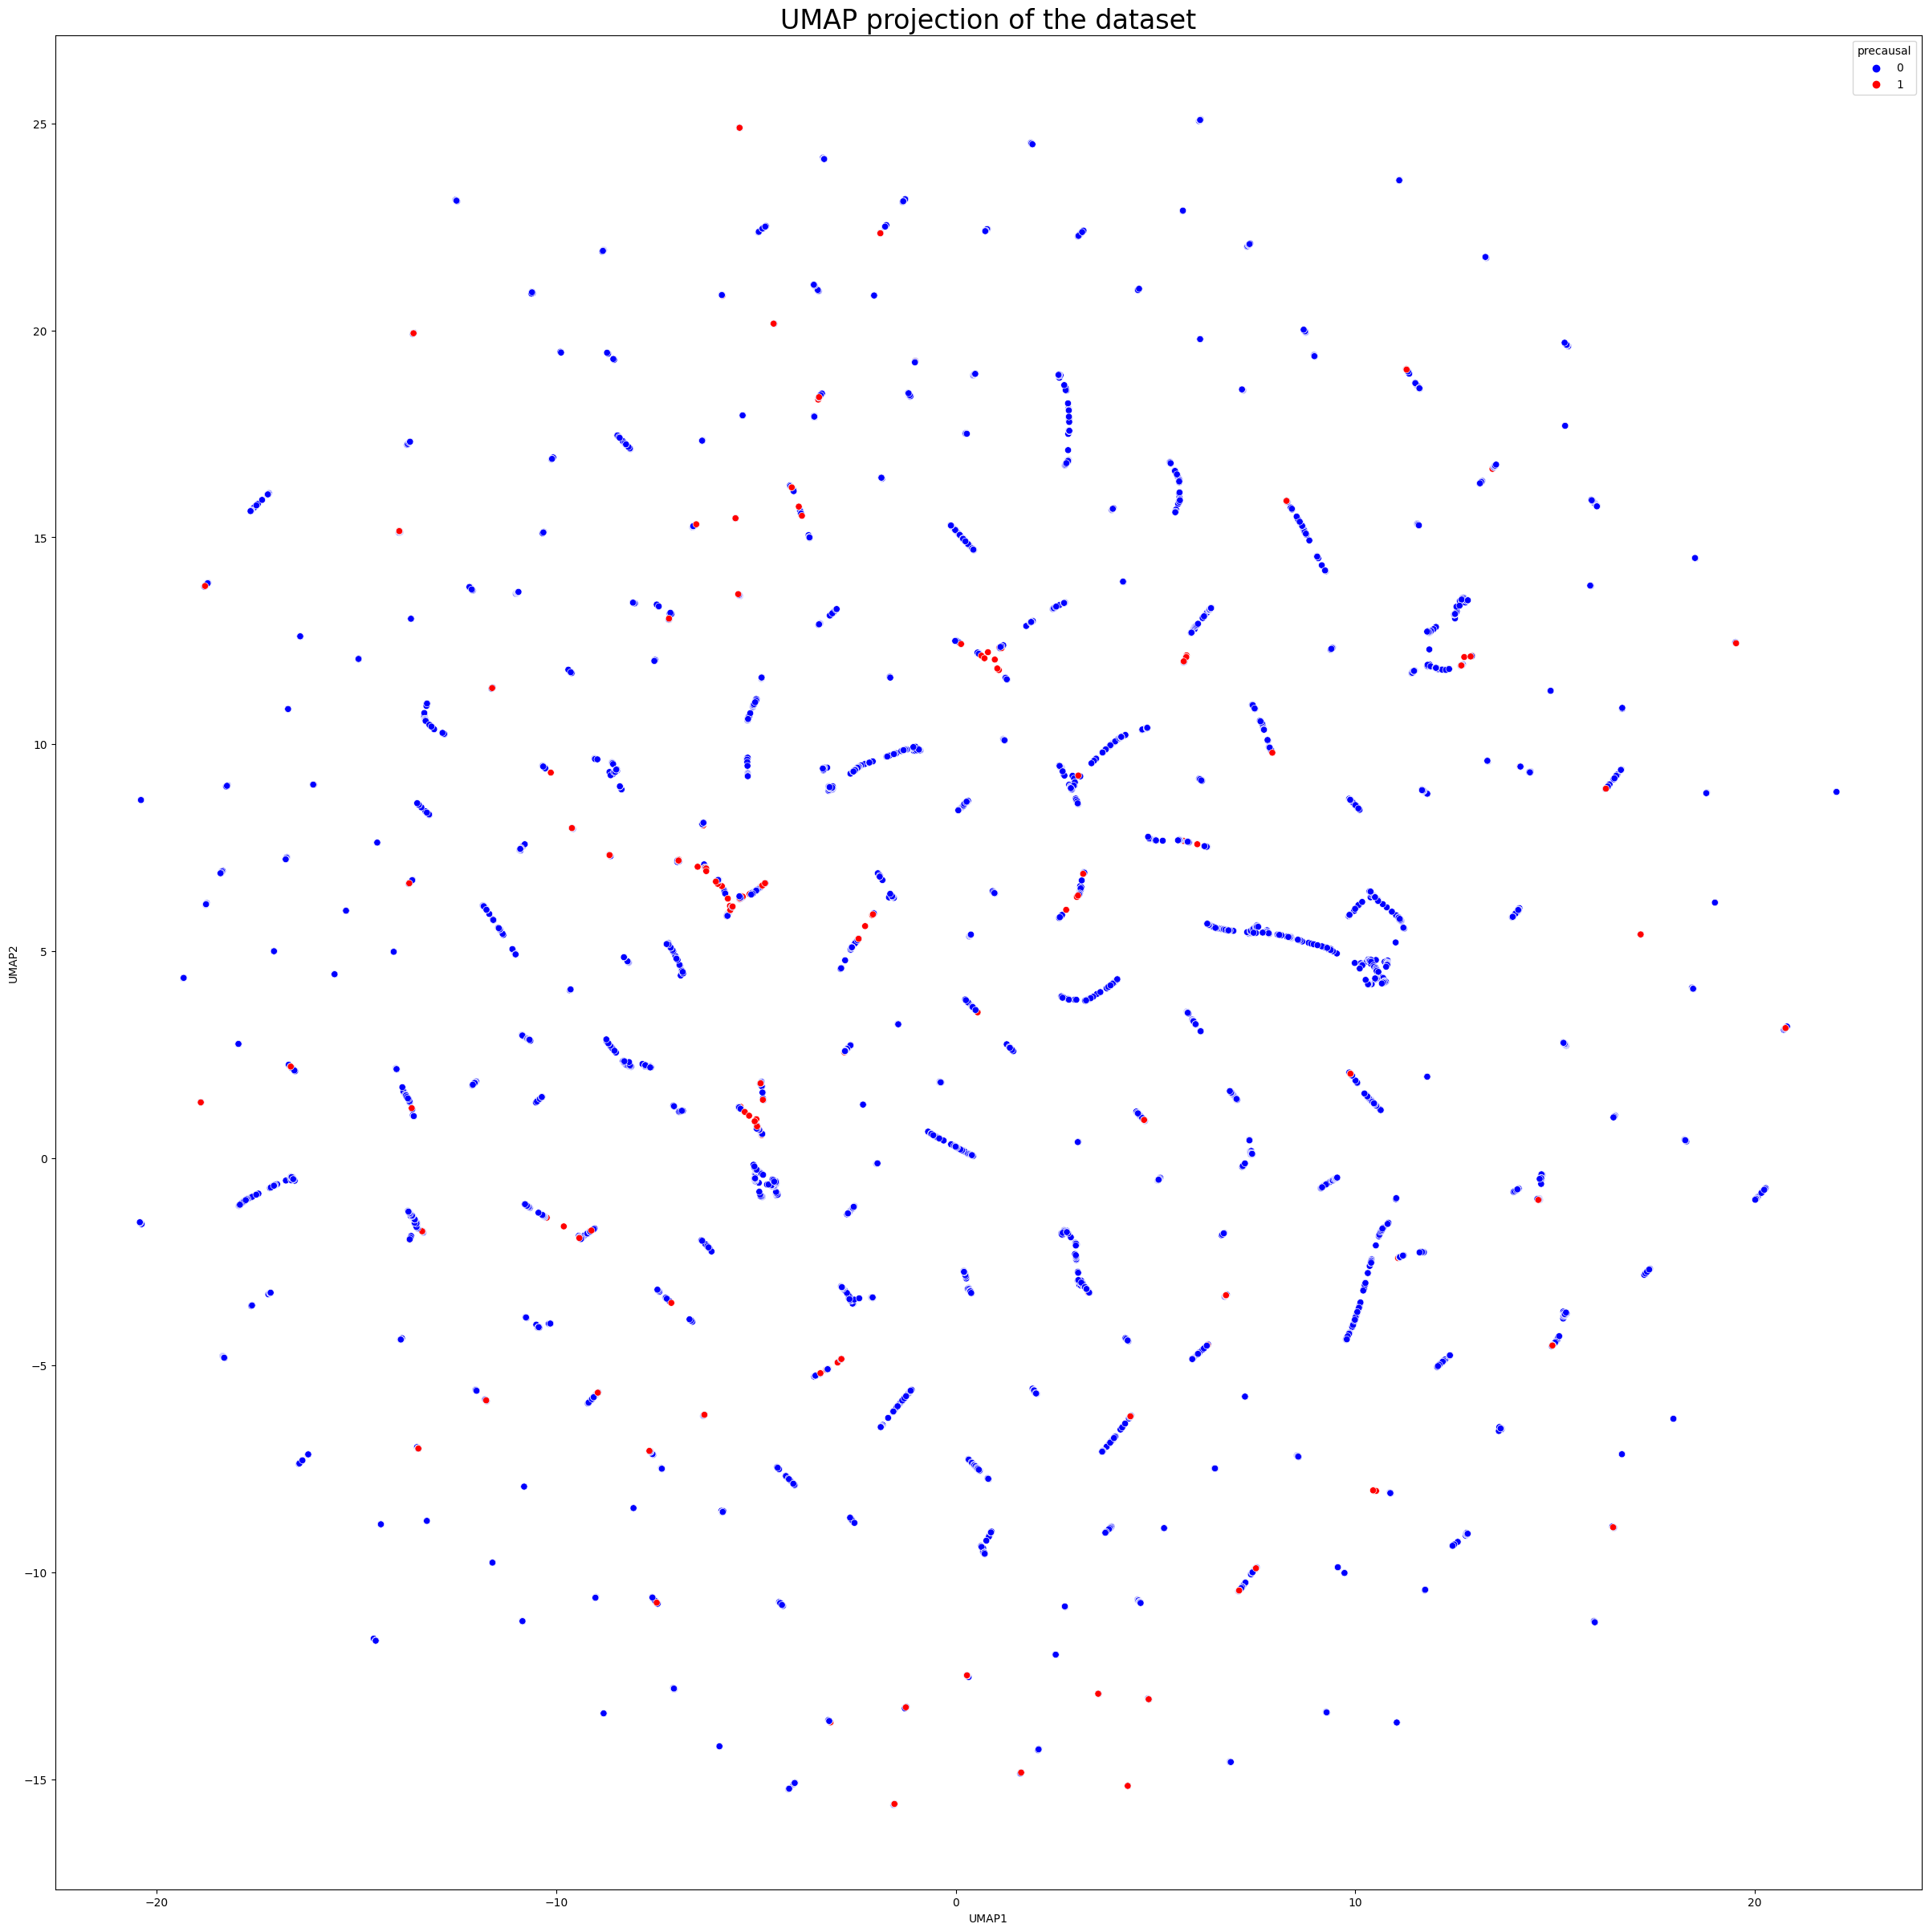

In [22]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from category_encoders import BinaryEncoder

# Load data
data = pd.read_csv('hyp-finemapped-precausal.csv', dtype=dtypes)

# Remove rows where 'nearest_genes' is missing
data = data.dropna(subset=['nearest_genes'])

# Store 'precausal' for later use and remove from data
precausal = data['precausal']

# Binary encode 'nearest_genes'
encoder = BinaryEncoder(cols=['nearest_genes'])
data = encoder.fit_transform(data)

# Select the desired columns for UMAP
cols_to_keep = ['#chrom', 'pos', 'mlogp', 'beta', 'sebeta','af_alt','af_alt_cases', 'af_alt_controls', 'nearest_genes_0', 'nearest_genes_1', 'nearest_genes_2', 'nearest_genes_3']
data = data[cols_to_keep]

# Use RobustScaler to normalize the columns
scaler = RobustScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Prepare data for UMAP
data_array = data.values

# Apply UMAP
reducer = umap.UMAP(random_state=seed)
embedding = reducer.fit_transform(data_array)

# Prepare DataFrame for Seaborn
umap_data = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_data['precausal'] = precausal

# Define palette for Seaborn
palette = {0: 'blue', 1: 'red'}

# Plot UMAP results, colored by 'precausal' using Seaborn
plt.figure(figsize=(30, 30))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='precausal', palette=palette, data=umap_data)
plt.title('UMAP projection of the dataset', fontsize=24)
plt.show()

In [30]:
import scipy.spatial

# Separate the UMAP results into two groups
umap_data_0 = umap_data[umap_data['precausal'] == 0][['UMAP1', 'UMAP2']]
umap_data_1 = umap_data[umap_data['precausal'] == 1][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances between the two groups
distances = scipy.spatial.distance.cdist(umap_data_1, umap_data_0, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=1 points and precausal=0 points is {average_distance}")

The average distance between precausal=1 points and precausal=0 points is 16.285995619865435


In [31]:
import scipy.spatial

# Select UMAP results where `precausal=1`
umap_data_1 = umap_data[umap_data['precausal'] == 1][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances within the group
distances = scipy.spatial.distance.pdist(umap_data_1, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=1 points is {average_distance}")


The average distance between precausal=1 points is 15.756240321543245


In [32]:
import scipy.spatial

# Select UMAP results where `precausal=0`
umap_data_0 = umap_data[umap_data['precausal'] == 0][['UMAP1', 'UMAP2']]

# Calculate the pairwise distances within the group
distances = scipy.spatial.distance.pdist(umap_data_0, metric='euclidean')

# Calculate the average distance
average_distance = np.median(distances)

print(f"The average distance between precausal=0 points is {average_distance}")


The average distance between precausal=0 points is 16.715100826728474
